# Thinking in tensors in PyTorch

Hands-on training  by [Piotr Migdał](https://p.migdal.pl) (2019). 

Version for [AI & NLP Workshop Day](https://nlpday.pl/), 31 May 2019, Warsaw, Poland: **Understanding LSTM and GRU networks in PyTorch**.


## NLP & AI: 2. Bracket grammar

To show grammar-detection (as opposed to just pattern-detection), we will try to teach a neural network to check if sequence of brackets is correct. 

While it is an artificial dataset, many other problems have similar structure, e.g.:

* sentences starting with a capital letter and ending with `.`, `?` or `!`,
* HTML and XML tags,
* various codes,
* etc.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
base_string = "()()" + (32 - 4) * " "
base_string

'()()                            '

In [3]:
def shuffle_string(s):
    indices = np.arange(len(s), dtype='uint8')
    np.random.shuffle(indices)
    return "".join(base_string[i] for i in indices)

In [6]:
shuffle_string(base_string)

'        (                )  )  ('

In [7]:
# of course, it is possible to check correctness manually
# we use it to generate data
def is_correct(seq):
    open_brackets = 0
    val = {"(": 1, " ": 0, ")": -1}
    for c in seq:
        open_brackets += val[c]
        if open_brackets < 0:
            return False
    return open_brackets == 0

In [8]:
is_correct("()()")

True

In [9]:
is_correct("()(")

False

In [10]:
is_correct("())(")

False

In [11]:
# generating the dataset

char2id = {" ": 0, "(": 1, ")": 2}

def generate_pairs(size, random_state=42):
    np.random.seed(random_state)
    X = np.zeros((size, 3, len(base_string)))
    Y = np.zeros((size), dtype='float32')
    for i in range(size):
        s = shuffle_string(base_string)
        Y[i] = float(is_correct(s))
        for j, c in enumerate(s):
            X[i, char2id[c], j] = 1.
    return X, Y

In [12]:
X, Y = generate_pairs(1000)

In [14]:
import seaborn as sns

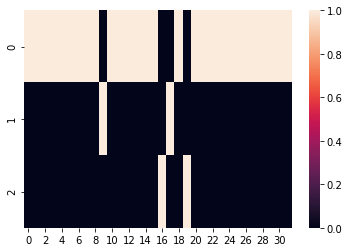

In [15]:
sns.heatmap(X[0])

In [16]:
# what is the fraction of correct strings?
Y.mean()

0.329

In [17]:
print(X.shape)
print(Y.shape)

(1000, 3, 32)
(1000,)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [20]:
X_test.shape

(250, 3, 32)

## Before we start...


We will create a few neural networks for detecting if brackets are properly matched:

* logistic regression
* convolutional neural network
* recurrent neural network (LSTM or GRU)

Which of these networks perform the best? Why?
Before we start, let's think:

* What is the baseline performance (accuracy)?
* What is the accuracy of the logistic regression model?
* Do you expect to perform much better than guessing the most common class all the time?

CNNs and RNNs will require some tweaking with the number of parameters.

Remember to adjust the optimizer and the number of epochs:

* learns to slowly -> more epochs or a higher learning rate (or change your optimizer),
* does not learn or scores fluctuate too much -> reduce the learning rate (or change your optimizer).

Also, let's install:

* `pip install livelossplot` - [Live training loss plot in Jupyter Notebook for Keras, PyTorch and others](https://github.com/stared/livelossplot/)

In [21]:
# if run from colab
!pip install -q livelossplot

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Training part

In [22]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from livelossplot import PlotLosses

In [23]:
trainloader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(),
                                       torch.from_numpy(Y_train).long()),
                         batch_size=16, shuffle=True)
testloader = DataLoader(TensorDataset(torch.from_numpy(X_test).float(),
                                      torch.from_numpy(Y_test).long()),
                         batch_size=16, shuffle=False)

dataloaders = {
    "train": trainloader,
    "validation": testloader
}

In [27]:
# train on cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.draw()

## Models

In [24]:
class Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(32 * 3, 2)
    
    def forward(self, x):
        x = self.fc(x.view(x.size(0), -1))
        return x

In [30]:
class Convolutional(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.convs = nn.Sequential(
            self._conv_block(3, channels),
            self._conv_block(channels, channels)
        )
        
        output_length = 32 // 2**len(self.convs)
        self.fc = nn.Linear(output_length * channels, 2)
    
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

In [32]:
class RecurrentLSTM(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=hidden_size)
        # note: input size is the numer of channels/embedding dim, NOT length
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = x.permute(2, 0, 1)  # BCL -> LBC
        output, (hidden, cell) = self.lstm(x)
        res = self.fc(cell).squeeze(0)
        return res

In [33]:
class RecurrentGRU(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.gru = nn.GRU(input_size=3, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = x.permute(2, 0, 1)  # BCL -> LBC 
        output, hidden = self.gru(x)
        res = self.fc(hidden).squeeze(0)
        return res

## Let's train!

In [28]:
# the same criterion for everything!
criterion = nn.CrossEntropyLoss()

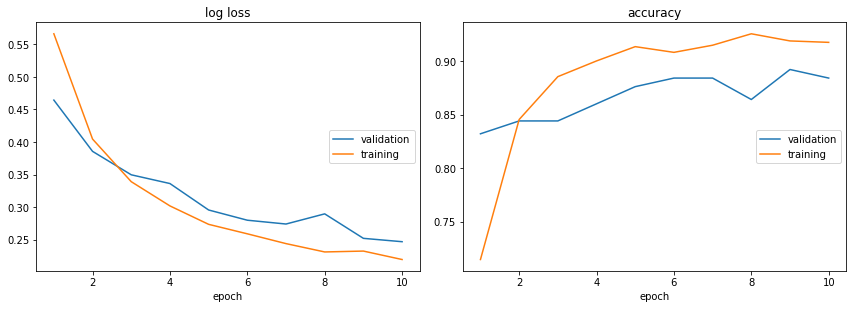

log loss:
validation (min:    0.247, max:    0.464, cur:    0.247)
training   (min:    0.220, max:    0.566, cur:    0.220)

accuracy:
validation (min:    0.832, max:    0.892, cur:    0.884)
training   (min:    0.715, max:    0.925, cur:    0.917)


In [29]:
model = Linear()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_model(model, criterion, optimizer, num_epochs=10)

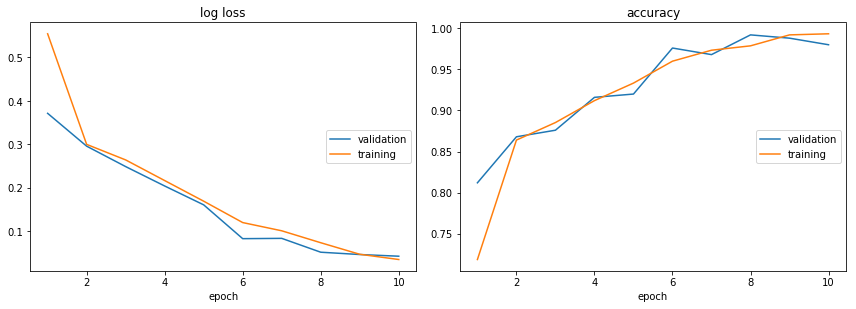

log loss:
validation (min:    0.042, max:    0.371, cur:    0.042)
training   (min:    0.035, max:    0.554, cur:    0.035)

accuracy:
validation (min:    0.812, max:    0.992, cur:    0.980)
training   (min:    0.719, max:    0.993, cur:    0.993)


In [31]:
model = Convolutional(channels=8)
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_model(model, criterion, optimizer, num_epochs=10)

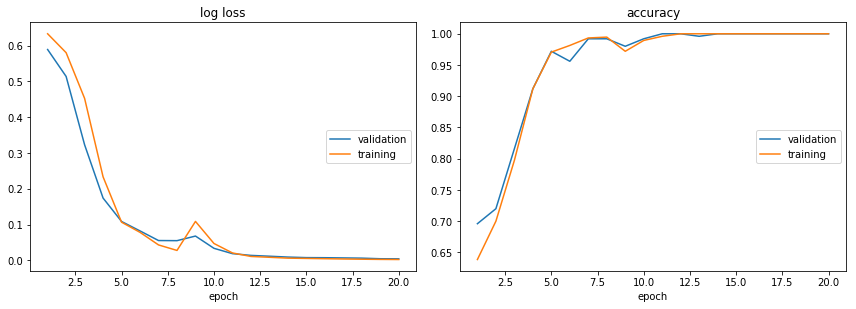

log loss:
validation (min:    0.004, max:    0.589, cur:    0.004)
training   (min:    0.002, max:    0.633, cur:    0.002)

accuracy:
validation (min:    0.696, max:    1.000, cur:    1.000)
training   (min:    0.639, max:    1.000, cur:    1.000)


In [34]:
model = RecurrentLSTM(hidden_size=8)
optimizer = optim.Adam(model.parameters(), lr=0.005)
train_model(model, criterion, optimizer, num_epochs=20)

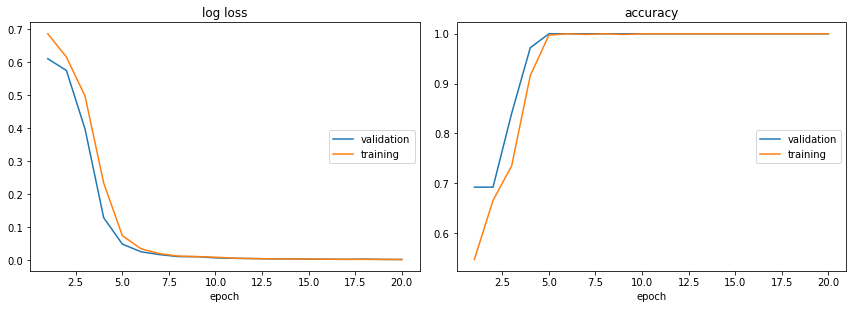

log loss:
validation (min:    0.001, max:    0.610, cur:    0.001)
training   (min:    0.001, max:    0.686, cur:    0.001)

accuracy:
validation (min:    0.692, max:    1.000, cur:    1.000)
training   (min:    0.547, max:    1.000, cur:    1.000)


In [36]:
model = RecurrentGRU(hidden_size=8)
optimizer = optim.Adam(model.parameters(), lr=0.005)
train_model(model, criterion, optimizer, num_epochs=20)

In [37]:
def predict_str(model, s):
    X = torch.zeros((1, 3, len(s)))
    for j, c in enumerate(s):
        X[0, char2id[c], j] = 1.
    return model(X).softmax(dim=1)[0, 1].item()

In [38]:
predict_str(model, "      (   (           )       ) ")

0.9996689558029175

In [39]:
predict_str(model, "      (   )           (       ) ")

0.9988895058631897

In [40]:
predict_str(model, "      )   )           (       ( ")

2.2779155187890865e-05

In [45]:
predict_str(model, "     ( (                                                   ) ) ")

0.9993332028388977

In [51]:
predict_str(model, "      (   )    )       ")

0.9857472777366638